# Import Libraries and Data

In [61]:
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

import xgboost as xgb

import tensorflow as tf
from tensorflow.keras import Sequential, optimizers, losses, layers

from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

%matplotlib inline

Data Courtesy of https://ieee-dataport.org/open-access/battery-and-heating-data-real-driving-cycles

In [2]:
# Import Trip Data Set
for dirname, _, filenames in os.walk('archive/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

archive/Overview.xlsx
archive/readin.m
archive/TripA01.csv
archive/TripA02.csv
archive/TripA03.csv
archive/TripA04.csv
archive/TripA05.csv
archive/TripA06.csv
archive/TripA07.csv
archive/TripA08.csv
archive/TripA09.csv
archive/TripA10.csv
archive/TripA11.csv
archive/TripA12.csv
archive/TripA13.csv
archive/TripA14.csv
archive/TripA15.csv
archive/TripA16.csv
archive/TripA17.csv
archive/TripA18.csv
archive/TripA19.csv
archive/TripA20.csv
archive/TripA21.csv
archive/TripA22.csv
archive/TripA23.csv
archive/TripA24.csv
archive/TripA25.csv
archive/TripA26.csv
archive/TripA27.csv
archive/TripA28.csv
archive/TripA29.csv
archive/TripA30.csv
archive/TripA31.csv
archive/TripA32.csv
archive/TripB01.csv
archive/TripB02.csv
archive/TripB03.csv
archive/TripB04.csv
archive/TripB05.csv
archive/TripB06.csv
archive/TripB07.csv
archive/TripB08.csv
archive/TripB09.csv
archive/TripB10.csv
archive/TripB11.csv
archive/TripB12.csv
archive/TripB13.csv
archive/TripB14.csv
archive/TripB15.csv
archive/TripB16.csv
a

In [3]:
overview = pd.read_excel("archive/Overview.xlsx")

In [27]:
overview.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Trip                              70 non-null     object 
 1   Date                              70 non-null     object 
 2   Route/Area                        70 non-null     object 
 3   Weather                           70 non-null     object 
 4   Battery Temperature (Start) [°C]  70 non-null     float64
 5   Battery Temperature (End)         70 non-null     float64
 6   Battery State of Charge (Start)   70 non-null     float64
 7   Battery State of Charge (End)     70 non-null     float64
 8   Delta Battery                     70 non-null     float64
 9   Ambient Temperature (Start) [°C]  70 non-null     float64
 10  Target Cabin Temperature          70 non-null     float64
 11  Distance [km]                     70 non-null     float64
 12  Duration [

In [26]:
# Column 8 refers to the change in battery from start to finish. We will rename to Delta Battery
overview.rename(columns={"Unnamed: 8": "Delta Battery"}, inplace=True)

# Column 13 is a empty column so we will delete it
# overview = overview.drop(columns=['Unnamed: 13'])

overview

,Trip,Date,Route/Area,Weather,Battery Temperature (Start) [°C],Battery Temperature (End),Battery State of Charge (Start),Battery State of Charge (End),Delta Battery,Ambient Temperature (Start) [°C],Target Cabin Temperature,Distance [km],Duration [min],Fan,Note
0,TripA01,2019-06-25_13-21-14,Munich East,sunny,21.0,22.0,0.863,0.803,0.060,25.5,23.0,7.427690,16.820000,"Automatic, Level 1",NaN
1,TripA02,2019-06-25_14-05-31,Munich East,sunny,23.0,26.0,0.803,0.673,0.130,32.0,23.0,23.509709,23.550000,"Automatic, Level 1",Target Cabin Temperature changed
2,TripA03,2019-06-28_10-02-15,Munich East,sunny,24.0,25.0,0.835,0.751,0.084,21.5,27.0,12.820846,11.180000,"Automatic, Level 1",Target Cabin Temperature changed
3,TripA04,2019-06-28_10-13-30,Munich East,sunny,25.0,27.0,0.751,0.667,0.084,24.0,22.0,10.727491,6.870000,"Automatic, Level 1",NaN
4,TripA05,2019-06-28_10-20-26,Munich East,sunny,27.0,27.0,0.667,0.602,0.065,24.5,24.0,12.393223,22.776667,"Automatic, Level 1",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,TripB34,2020-01-14_12-55-08,Munich North,cloudy,11.0,11.0,0.739,0.713,0.026,5.5,22.0,9.143200,12.228333,"Automatic, Level 1",+ 160 kg
68,TripB35,2020-01-14_17-59-06,Munich North,dark,11.0,13.0,0.854,0.715,0.139,4.0,22.0,15.419300,22.708333,"Automatic, Level 1",NaN
69,TripB36,2020-01-15_10-43-44,Munich North,sunny,6.0,10.0,0.721,0.445,0.276,4.0,22.0,38.718800,47.536667,"Automatic, Level 1",Open door at 37:10 and 42:00 for 30s
70,TripB37,2020-01-21_09-15-20,Munich East,slightly cloudy,8.0,10.0,0.838,0.680,0.158,-3.0,22.0,17.462600,23.620000,"Automatic, Level 1",NaN


In [4]:
def combine_csv():
    df_main = pd.DataFrame()
    for filename in glob.glob('archive/'+'*.csv'):
        df_trip = pd.read_csv(filename, sep=';', encoding="unicode_escape")
        
        if 'Velocity [km/h]]]' in df_trip.columns:
            df_trip.rename(columns={"Velocity [km/h]]]": "Velocity [km/h]"}, inplace=True)
            
        df_main = pd.concat([df_main, df_trip])

    df_main.to_csv('All_Trips.csv', index=False)
    return df_main.head(3)

# combine_csv()

# Exploratory Data Analysis

In [17]:
all_trips = pd.read_csv("All_Trips.csv")

In [18]:
all_trips.columns

Index(['Time [s]', 'Velocity [km/h]', 'Elevation [m]', 'Throttle [%]',
       'Motor Torque [Nm]', 'Longitudinal Acceleration [m/s^2]',
       'Regenerative Braking Signal ', 'Battery Voltage [V]',
       'Battery Current [A]', 'Battery Temperature [°C]',
       'max. Battery Temperature [°C]', 'SoC [%]', 'displayed SoC [%]',
       'min. SoC [%]', 'max. SoC [%)', 'Heating Power CAN [kW]',
       'Heating Power LIN [W]', 'Requested Heating Power [W]',
       'AirCon Power [kW]', 'Heater Signal', 'Heater Voltage [V]',
       'Heater Current [A]', 'Ambient Temperature [°C]',
       'Coolant Temperature Heatercore [°C]',
       'Requested Coolant Temperature [°C]', 'Coolant Temperature Inlet [°C]',
       'Heat Exchanger Temperature [°C]', 'Cabin Temperature Sensor [°C]',
       'Unnamed: 23', 'Ambient Temperature Sensor [°C]',
       'Coolant Volume Flow +500 [l/h]',
       'Temperature Coolant Heater Inlet [°C]',
       'Temperature Coolant Heater Outlet [°C]',
       'Temperature Heat 

In [19]:
all_trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1094793 entries, 0 to 1094792
Data columns (total 49 columns):
 #   Column                                  Non-Null Count    Dtype  
---  ------                                  --------------    -----  
 0   Time [s]                                1094793 non-null  float64
 1   Velocity [km/h]                         1094793 non-null  float64
 2   Elevation [m]                           1094793 non-null  float64
 3   Throttle [%]                            1094793 non-null  float64
 4   Motor Torque [Nm]                       1094793 non-null  float64
 5   Longitudinal Acceleration [m/s^2]       1094793 non-null  float64
 6   Regenerative Braking Signal             1094793 non-null  float64
 7   Battery Voltage [V]                     1094793 non-null  float64
 8   Battery Current [A]                     1094793 non-null  float64
 9   Battery Temperature [°C]                1094793 non-null  float64
 10  max. Battery Temperature [°C] 

In [20]:
all_trips = all_trips.drop(columns=['displayed SoC [%]', 'Coolant Temperature Heatercore [°C]',
       'Requested Coolant Temperature [°C]', 'Coolant Temperature Inlet [°C]',
       'Heat Exchanger Temperature [°C]', 'Cabin Temperature Sensor [°C]',
       'Unnamed: 23', 'Ambient Temperature Sensor [°C]',
       'min. SoC [%]', 'max. SoC [%)', 'Coolant Volume Flow +500 [l/h]',
       'Requested Heating Power [W]', 'Temperature Coolant Heater Inlet [°C]',
       'Heater Voltage [V]', 'Heater Current [A]', 'Temperature Coolant Heater Outlet [°C]',
       'Temperature Heat Exchanger Outlet [°C]', 'Heating Power LIN [W]',
       'Temperature Defrost lateral left [°C]',
       'Temperature Defrost lateral right [°C]',
       'Temperature Defrost central [°C]',
       'Temperature Defrost central left [°C]',
       'Temperature Defrost central right [°C]',
       'Temperature Footweel Driver [°C]',
       'Temperature Footweel Co-Driver [°C]',
       'Temperature Feetvent Co-Driver [°C]',
       'Temperature Feetvent Driver [°C]', 'Temperature Head Co-Driver [°C]',
       'Temperature Head Driver [°C]', 'Temperature Vent right [°C] ',
       'Temperature Vent central right [°C]',
       'Temperature Vent central left [°C]', 'Temperature Vent right [°C]'], axis=1)

all_trips.columns

Index(['Time [s]', 'Velocity [km/h]', 'Elevation [m]', 'Throttle [%]',
       'Motor Torque [Nm]', 'Longitudinal Acceleration [m/s^2]',
       'Regenerative Braking Signal ', 'Battery Voltage [V]',
       'Battery Current [A]', 'Battery Temperature [°C]',
       'max. Battery Temperature [°C]', 'SoC [%]', 'Heating Power CAN [kW]',
       'AirCon Power [kW]', 'Heater Signal', 'Ambient Temperature [°C]'],
      dtype='object')

In [23]:
all_trips = all_trips.dropna()
all_trips.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1064000 entries, 0 to 1094792
Data columns (total 16 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   Time [s]                           1064000 non-null  float64
 1   Velocity [km/h]                    1064000 non-null  float64
 2   Elevation [m]                      1064000 non-null  float64
 3   Throttle [%]                       1064000 non-null  float64
 4   Motor Torque [Nm]                  1064000 non-null  float64
 5   Longitudinal Acceleration [m/s^2]  1064000 non-null  float64
 6   Regenerative Braking Signal        1064000 non-null  float64
 7   Battery Voltage [V]                1064000 non-null  float64
 8   Battery Current [A]                1064000 non-null  float64
 9   Battery Temperature [°C]           1064000 non-null  float64
 10  max. Battery Temperature [°C]      1064000 non-null  float64
 11  SoC [%]                      

In [30]:
all_trips['Regenerative Braking Signal '] = all_trips['Regenerative Braking Signal '].apply(lambda x: 1 if x != 0 else 0)

print(all_trips['Regenerative Braking Signal '].value_counts())

Regenerative Braking Signal 
0    1006883
1      57117
Name: count, dtype: int64


In [31]:
all_trips['Heater Signal'] = all_trips['Heater Signal'].apply(lambda x: 1 if x != 0 else 0)

print(all_trips['Heater Signal'].value_counts())

Heater Signal
1    981358
0     82642
Name: count, dtype: int64


In [28]:
def plot_df_subplots(df, nrows, ncols, figsize=(30,24)):
    ''' Create a subplot of all the factors and their changes across time'''
    factors = list(df.columns)
    plt.figure(figsize=figsize)
    
    for idx, key in enumerate(factors):
        plt.subplot(nrows, ncols, idx+1)
        plt.plot(np.array(range(df.shape[0]))*0.1, df[key])
        plt.ylabel(key)
        plt.grid(True)
        plt.xlabel(factors[0])
        plt.show

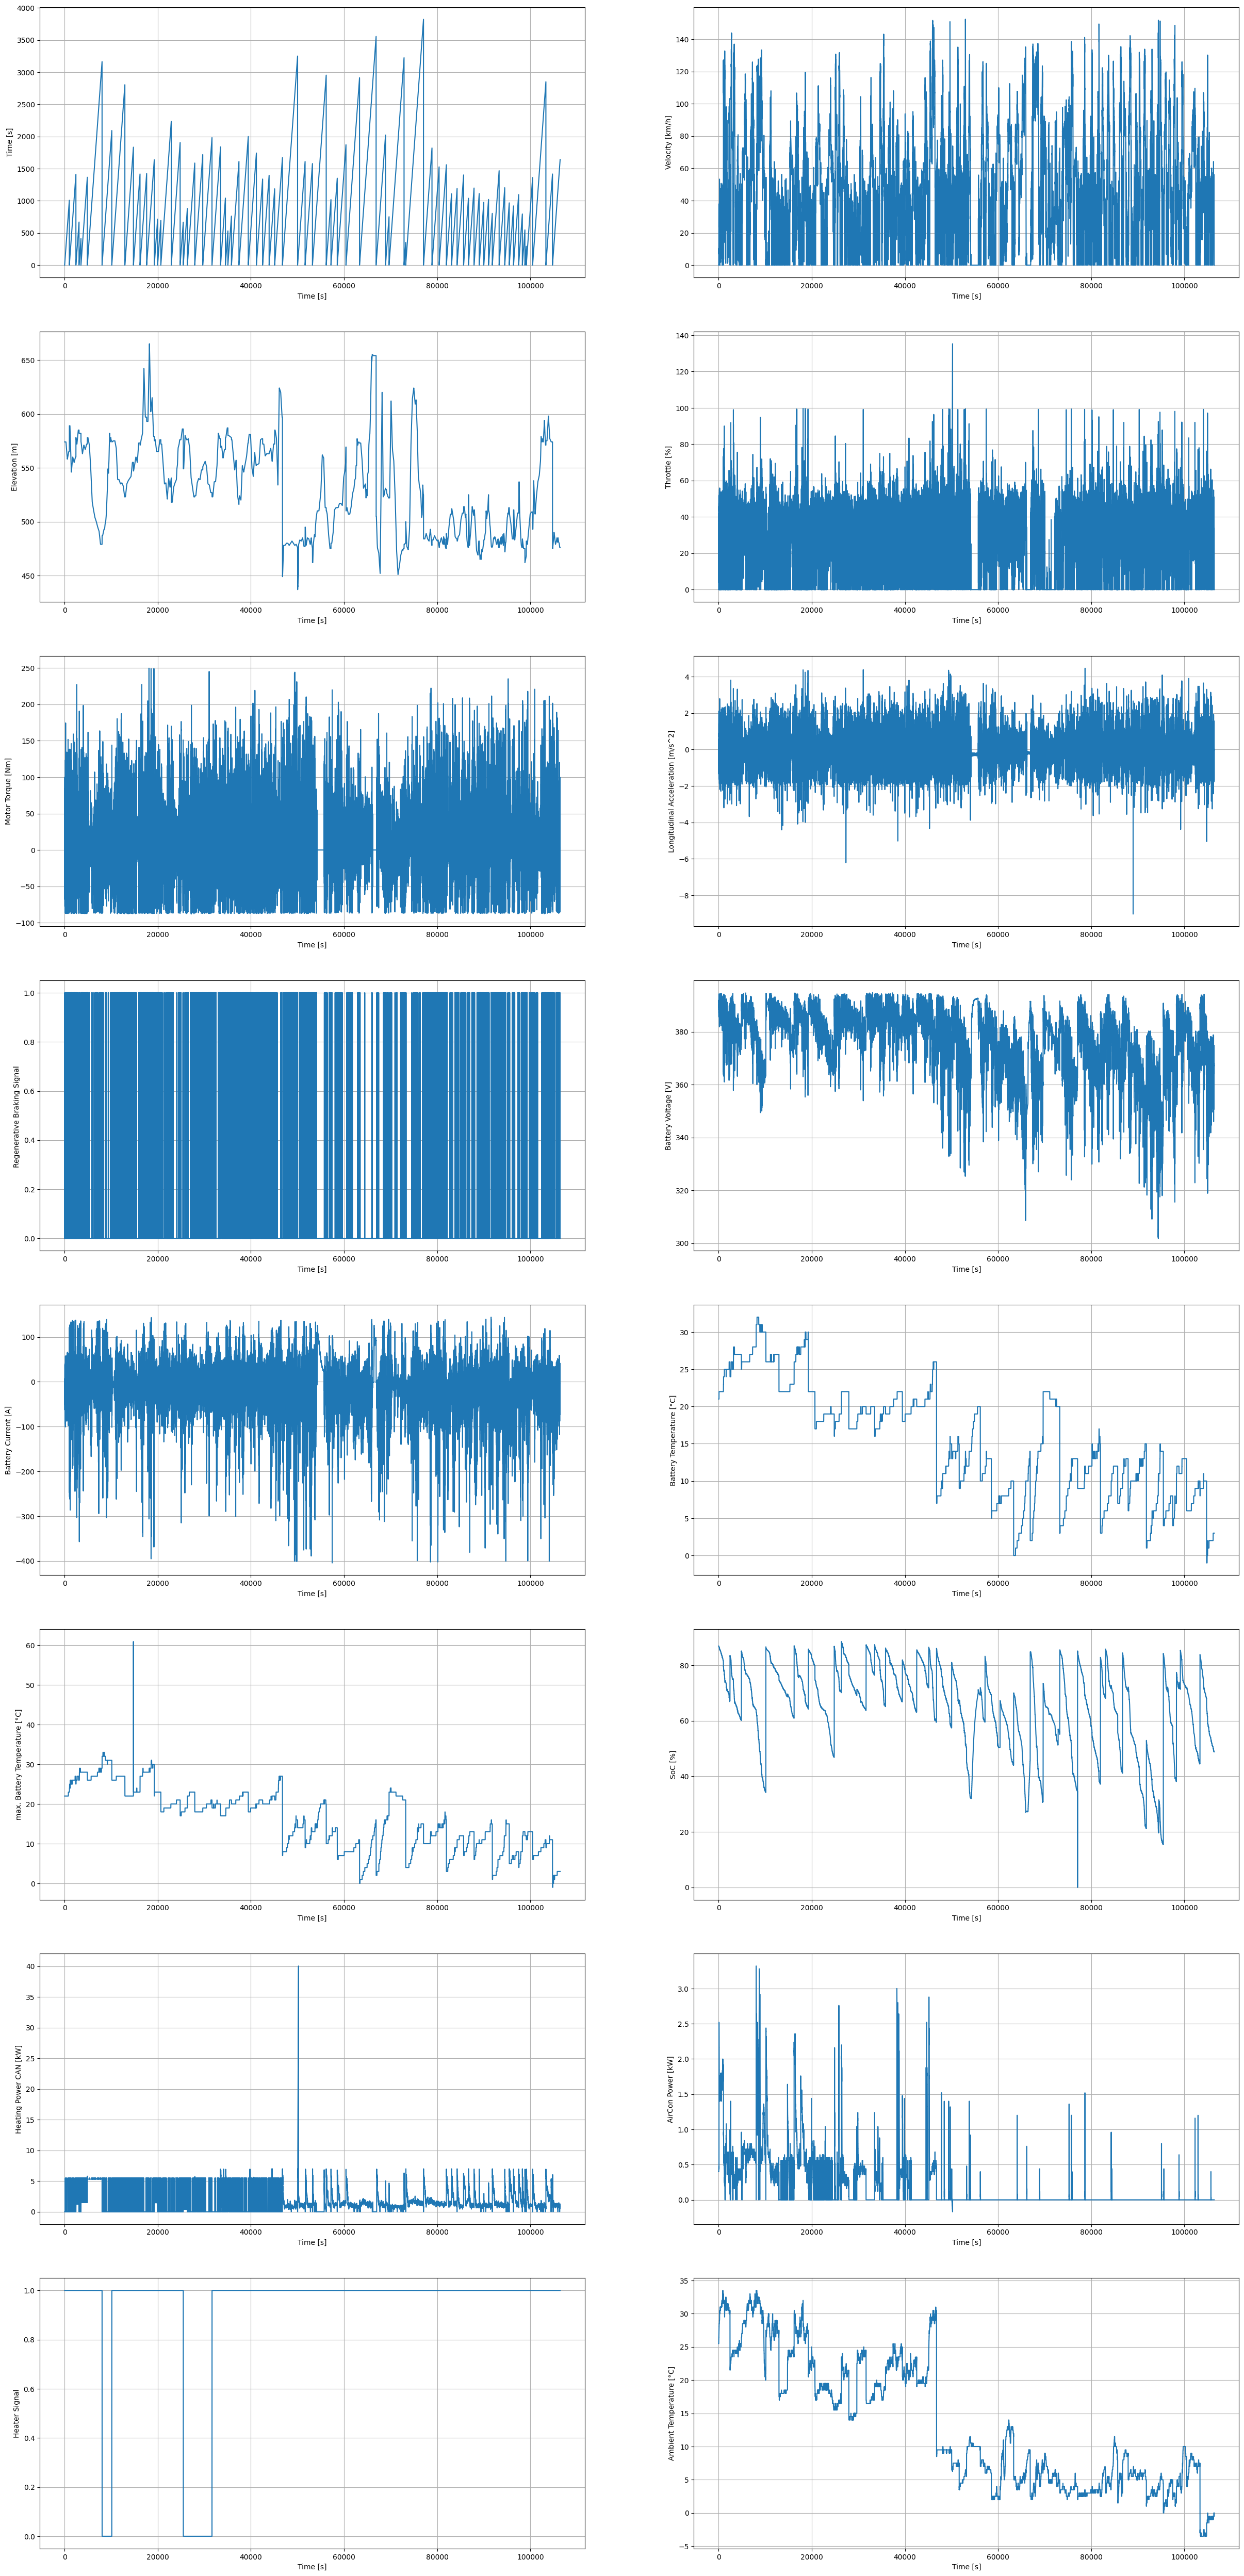

In [33]:
plot_df_subplots(all_trips, nrows=8, ncols=2, figsize=(30,64))

<Axes: >

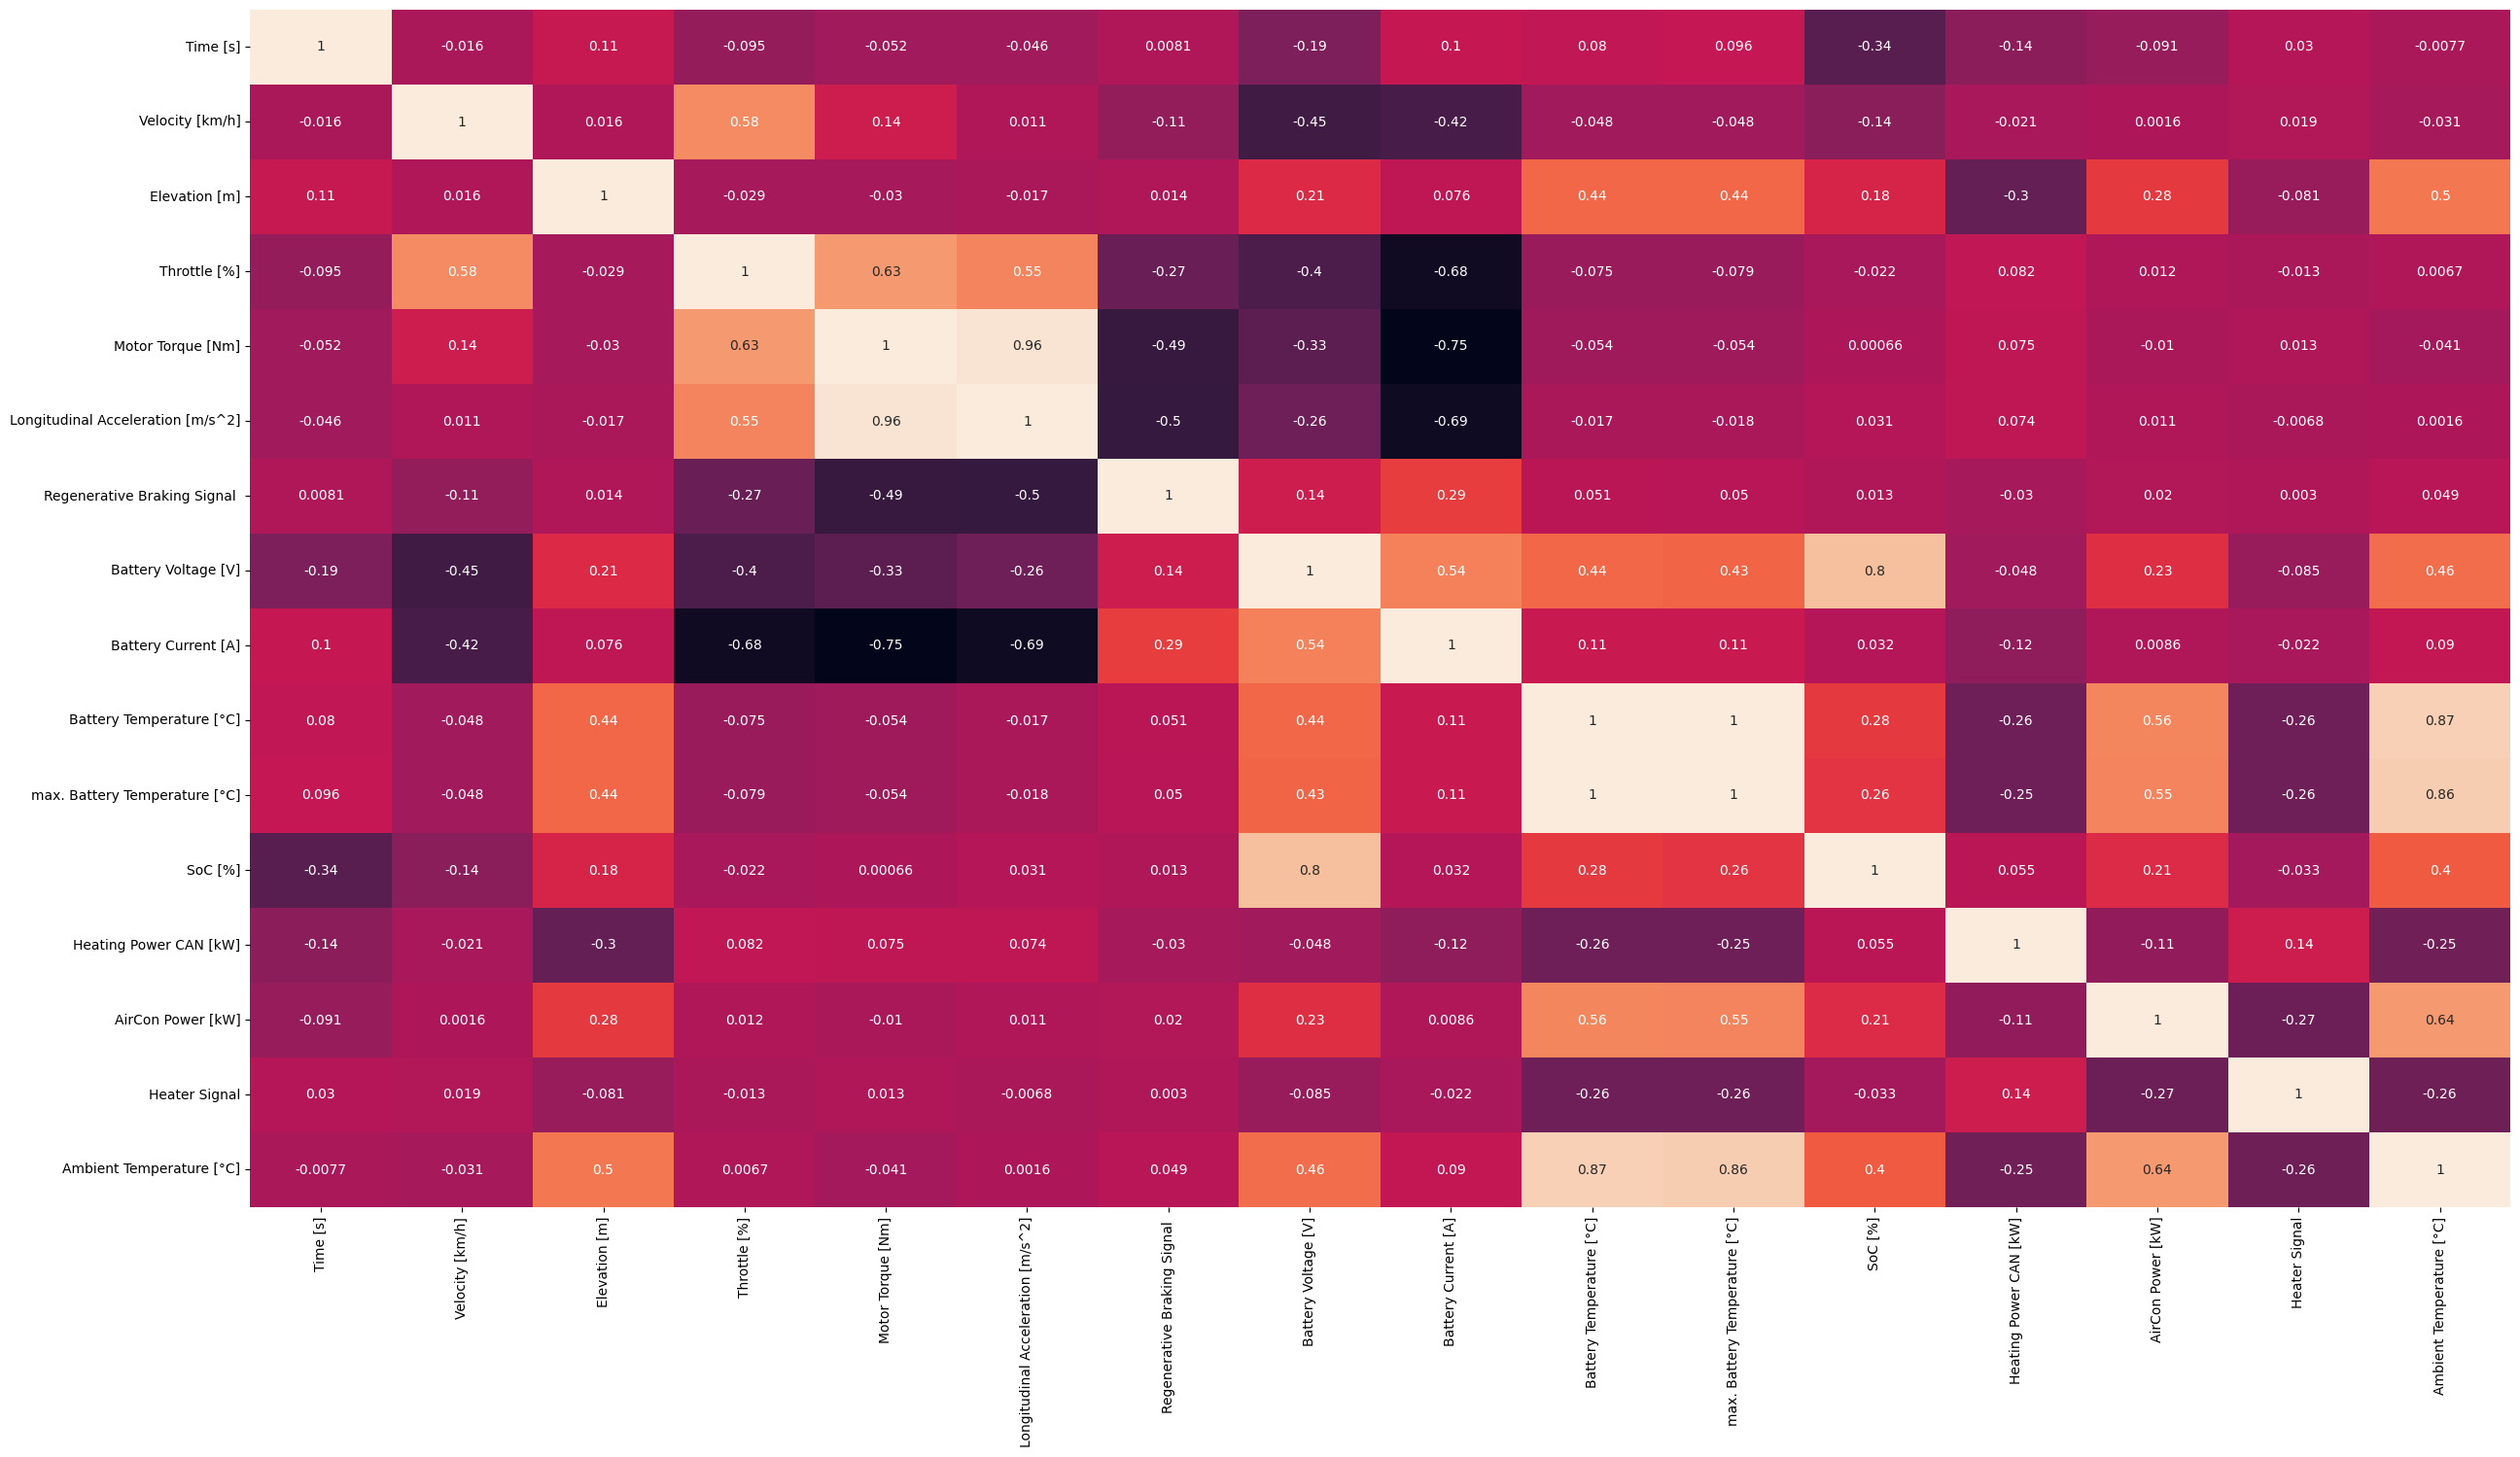

In [32]:
plt.figure(figsize=(30,16))
sns.heatmap(all_trips.corr(), annot=True, cbar=False)

# Modeling

### Train Test split

In [35]:
all_trips.columns

Index(['Time [s]', 'Velocity [km/h]', 'Elevation [m]', 'Throttle [%]',
       'Motor Torque [Nm]', 'Longitudinal Acceleration [m/s^2]',
       'Regenerative Braking Signal ', 'Battery Voltage [V]',
       'Battery Current [A]', 'Battery Temperature [°C]',
       'max. Battery Temperature [°C]', 'SoC [%]', 'Heating Power CAN [kW]',
       'AirCon Power [kW]', 'Heater Signal', 'Ambient Temperature [°C]'],
      dtype='object')

In [44]:
# Identify predictors and outcome of the regression model.
predictors = ['Velocity [km/h]', 'Elevation [m]', 'Throttle [%]',
       'Motor Torque [Nm]', 'Longitudinal Acceleration [m/s^2]',
       'Regenerative Braking Signal ', 'Battery Voltage [V]',
       'Battery Current [A]', 'Battery Temperature [°C]',
       'max. Battery Temperature [°C]','Heating Power CAN [kW]',
       'AirCon Power [kW]', 'Heater Signal', 'Ambient Temperature [°C]']
outcome =  'SoC [%]'

# Identify X and y variables for regression and partition data
# using 60% of records for training and 40% for validation 
# (test_size=0.4). 
X = all_trips[predictors]
y = all_trips[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=0)

## Simple Linear Regression

In [45]:
# Create multiple linear regression model using X and y
# and LinearRegression() function from sklearn (skikit-learn) 
# library.
trip_lm = LinearRegression()
trip_lm.fit(train_X, train_y)

# Display intercept and regression coefficients. Round
# them to 2 decimals.
print('Regression Model for All Trips Training Set')
print()
print('Intercept: ', np.round(trip_lm.intercept_, 2))
print(pd.DataFrame({'Predictor': X.columns, 'Coefficient': np.round(trip_lm.coef_, 2)}))


Regression Model for All Trips Training Set

Intercept:  -534.54
                            Predictor  Coefficient
0                     Velocity [km/h]         0.07
1                       Elevation [m]         0.01
2                        Throttle [%]        -0.01
3                   Motor Torque [Nm]        -0.03
4   Longitudinal Acceleration [m/s^2]         0.60
5        Regenerative Braking Signal          0.78
6                 Battery Voltage [V]         1.57
7                 Battery Current [A]        -0.21
8            Battery Temperature [°C]         0.42
9       max. Battery Temperature [°C]        -1.12
10             Heating Power CAN [kW]         0.13
11                  AirCon Power [kW]         0.99
12                      Heater Signal         0.71
13           Ambient Temperature [°C]         0.23


In [40]:
# Use predict() to score (make) predictions for validation set.
trip_lm_pred = trip_lm.predict(valid_X)

# Develop and display data frame with actual values of Price,
# scoring (predicted) results, and residuals.
# Use round() function to round vlaues in data frame to 
# 2 decimals. 
print('Actual, Prediction, and Residual Prices for Validation Set')
result = round(pd.DataFrame({'Actual': valid_y,'Predicted': trip_lm_pred, 
                       'Residual': valid_y - trip_lm_pred}), 2)
print(result.head(10))

Actual, Prediction, and Residual Prices for Validation Set
         Actual  Predicted  Residual
1090766    51.0      50.18      0.82
165728     84.3      77.50      6.80
54566      80.7      83.56     -2.86
443787     77.6      74.90      2.70
303610     68.3      70.34     -2.04
876656     63.6      62.02      1.58
377076     76.6      77.05     -0.45
996499     59.8      55.71      4.09
614250     63.2      63.86     -0.66
760925     83.4      83.16      0.24


In [41]:
# Use predict() function to make predictions for
# training set.
pred_y = trip_lm.predict(train_X)

# Create prediction performance measures for training set.
r2 = round(r2_score(train_y, pred_y),3)
adj_r2 = round(adjusted_r2_score(train_y, pred_y, trip_lm),3)
aic = round(AIC_score(train_y, pred_y, trip_lm),2)
bic = round(BIC_score(train_y, pred_y, trip_lm),2)

# Display prediction performance measures for training set.
print('Prediction Performance Measures for Training Set')
print('r2 : ', r2)
print('Adjusted r2 : ', adj_r2)
print('AIC : ', aic)
print('BIC : ', bic)
print() 

# Create prediction performance measures for validation set.
r2 = round(r2_score(valid_y, trip_lm_pred),3)
adj_r2 = round(adjusted_r2_score(valid_y, trip_lm_pred, trip_lm),3)
aic = round(AIC_score(valid_y, trip_lm_pred, trip_lm),2)
bic = round(BIC_score(valid_y, trip_lm_pred, trip_lm),2)

# Display prediction performance measures for validation set.
print('Prediction Performance Measures for Validation Set')
print('r2 : ', r2)
print('adjusted r2 : ', adj_r2)
print('AIC : ', aic)
print('BIC : ', bic)

Prediction Performance Measures for Training Set
r2 :  0.927
Adjusted r2 :  0.927
AIC :  3610251.14
BIC :  3610433.01

Prediction Performance Measures for Validation Set
r2 :  0.927
adjusted r2 :  0.927
AIC :  2404854.31
BIC :  2405029.69


In [43]:
# Display common accuracy measures for training set.
print('Accuracy Measures for Training Set - All Variables')
regressionSummary(train_y, pred_y)
print()

# Display common accuracy measures for validation set.
print('Accuracy Measures for Validation Set - All Variables')
regressionSummary(valid_y, trip_lm_pred)

Accuracy Measures for Training Set - All Variables

Regression statistics

               Mean Error (ME) : -0.0000
Root Mean Squared Error (RMSE) : 4.0903
     Mean Absolute Error (MAE) : 2.9830

Accuracy Measures for Validation Set - All Variables

Regression statistics

                      Mean Error (ME) : 0.0012
       Root Mean Squared Error (RMSE) : 4.0807
            Mean Absolute Error (MAE) : 2.9766
          Mean Percentage Error (MPE) : -0.3532
Mean Absolute Percentage Error (MAPE) : 5.4119


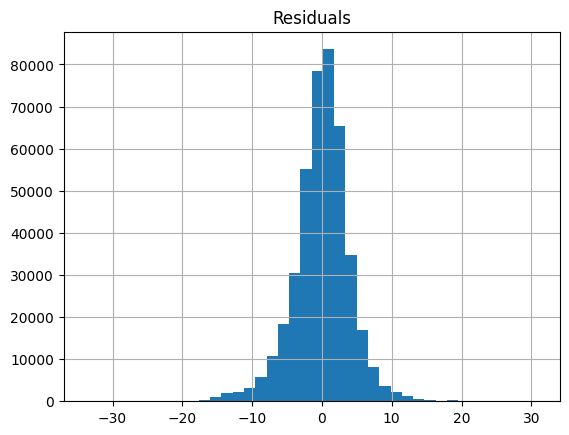

In [55]:
# Identify validation residuals of the regression model
# to check if they have approximately normal distribution.
trip_lm_pred = trip_lm.predict(valid_X)
all_residuals = valid_y - trip_lm_pred

# Develop data frame for the histogram using hist()
# function.
ax = pd.DataFrame({'Residuals': all_residuals}).hist(bins=40)

# Show histogram plot. 
# plt.tight_layout()
plt.show()

## Statsmodel Linear Regression

In [50]:
# Apply sm.ols() function from statsmodels library
# to run a linear regression of Price on the 
# 11 predictors (including 2 dummy variables)
# in the training set.

# Create a data frame that inlcudes 11 predictors and
# outcome (Price) for training set.
train_df_sm = train_X.join(train_y)

# Display columns in train_df data frame.
train_df_sm.columns

Index(['Velocity [km/h]', 'Elevation [m]', 'Throttle [%]', 'Motor Torque [Nm]',
       'Longitudinal Acceleration [m/s^2]', 'Regenerative Braking Signal ',
       'Battery Voltage [V]', 'Battery Current [A]',
       'Battery Temperature [°C]', 'max. Battery Temperature [°C]',
       'Heating Power CAN [kW]', 'AirCon Power [kW]', 'Heater Signal',
       'Ambient Temperature [°C]', 'SoC [%]'],
      dtype='object')

In [51]:
# Create predictors for the model.
predictors_sm = train_X.columns

# Develop regression model formula, where
# Price is outcome and 11 predictors. 
formula = 'train_y ~ ' + ' + '.join(predictors_sm)

# Create multiple regression model using sm.ols()
# function from statsmodels library.
trip_lm_sm = sm.ols(formula=formula, data=train_df_sm).fit()

# Display regression summary.
print(trip_lm_sm.summary()) 

# The regression coefficients are the same as for the 
# regression model using LinearRegression() function 
# from scikit-learn library.

PatsyError: error tokenizing input (maybe an unclosed string?)
    train_y ~ Velocity [km/h] + Elevation [m] + Throttle [%] + Motor Torque [Nm] + Longitudinal Acceleration [m/s^2] + Regenerative Braking Signal  + Battery Voltage [V] + Battery Current [A] + Battery Temperature [°C] + max. Battery Temperature [°C] + Heating Power CAN [kW] + AirCon Power [kW] + Heater Signal + Ambient Temperature [°C]
                                                                                                                                                                                                                       ^

## Forward Selection Algorithm

In [56]:
# Define train_model() function used in Forward Selection
# algorithm with forward_selection() function. 
# The initial model is the constant model - this requires 
# special handling in train_model and score_model.
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

# Define score_model() function used in Forward Selection
# algorithm with forward_selection() function. 
def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_X[variables]), model)

# Use forward_selection() function to identify the
# best_model and best_variables.
best_model_fs, best_variables_fs = forward_selection(train_X.columns, 
                    train_model, score_model, verbose=True)

# Display best variables based on Forward Selection algorithm.
print()
print('Best Variables from Forward Selection Algorithm')
print(best_variables_fs)

Variables: Velocity [km/h], Elevation [m], Throttle [%], Motor Torque [Nm], Longitudinal Acceleration [m/s^2], Regenerative Braking Signal , Battery Voltage [V], Battery Current [A], Battery Temperature [°C], max. Battery Temperature [°C], Heating Power CAN [kW], AirCon Power [kW], Heater Signal, Ambient Temperature [°C]
Start: score=5278735.64, constant
Step: score=4625263.91, add Battery Voltage [V]
Step: score=4017553.77, add Battery Current [A]
Step: score=3878757.90, add max. Battery Temperature [°C]
Step: score=3708401.89, add Velocity [km/h]
Step: score=3643266.86, add Ambient Temperature [°C]
Step: score=3628221.56, add Motor Torque [Nm]
Step: score=3619674.61, add Elevation [m]
Step: score=3616823.38, add AirCon Power [kW]
Step: score=3615102.99, add Heating Power CAN [kW]
Step: score=3613298.28, add Battery Temperature [°C]
Step: score=3611960.26, add Heater Signal
Step: score=3611238.40, add Throttle [%]
Step: score=3610580.46, add Regenerative Braking Signal 
Step: score=36

In [58]:
# Develop the multiple linear regression model based
# on the Forward Selection results.

# Identify predictors and outcome of the regression model.
predictors_fs = ['Battery Voltage [V]', 'Battery Current [A]', 'max. Battery Temperature [°C]', 
                 'Velocity [km/h]', 'Ambient Temperature [°C]', 'Motor Torque [Nm]', 'Elevation [m]', 
                 'AirCon Power [kW]', 'Heating Power CAN [kW]', 'Battery Temperature [°C]', 'Heater Signal', 
                 'Throttle [%]', 'Regenerative Braking Signal ', 'Longitudinal Acceleration [m/s^2]']
outcome = 'SoC [%]'

# Identify X and y variables for regression and partition data
# using 60% of records for training and 40% for validation 
# (test_size=0.4). 
X = all_trips[predictors_fs]
y = all_trips[outcome]
train_X_fs, valid_X_fs, train_y_fs, valid_y_fs = \
          train_test_split(X, y, test_size=0.4, random_state=1)

# Create multiple linear regression model using X and y.
car_fs = LinearRegression()
car_fs.fit(train_X_fs, train_y_fs)

# Display intercept and regression coefficients. Round them
# to 2 decimals.
print('Regression Model for Training Set Using Forward Selection')
print()
print('Intercept ', np.round(car_fs.intercept_, 2))
print(pd.DataFrame({'Predictor': X.columns,
            'Coefficient': np.round(car_fs.coef_, 2)}))

Regression Model for Training Set Using Forward Selection

Intercept  -534.12
                            Predictor  Coefficient
0                 Battery Voltage [V]         1.57
1                 Battery Current [A]        -0.21
2       max. Battery Temperature [°C]        -1.13
3                     Velocity [km/h]         0.07
4            Ambient Temperature [°C]         0.23
5                   Motor Torque [Nm]        -0.03
6                       Elevation [m]         0.01
7                   AirCon Power [kW]         0.99
8              Heating Power CAN [kW]         0.13
9            Battery Temperature [°C]         0.44
10                      Heater Signal         0.73
11                       Throttle [%]        -0.01
12       Regenerative Braking Signal          0.76
13  Longitudinal Acceleration [m/s^2]         0.60


In [59]:
# Use predict() to score predictions for validation set.
car_fs_pred = car_fs.predict(valid_X_fs)

# Develop and display data frame with actual values of Price,
# scoring (predicted) results, and residuals.
# Use round() function to round vlaues in data frame to 
# 2 decimals. 
result = round(pd.DataFrame({'Actual': valid_y_fs,'Predicted': car_fs_pred, 
                       'Residual': valid_y_fs - car_fs_pred}), 2)
print()
print('Predictions for Validation Set Using Forward Selection')
print(result.head(10))

# Display common accuracy measures for validation set.
print()
print('Accuracy Measures for Validation Set Using Forward Selection')
regressionSummary(valid_y_fs, car_fs_pred)


Predictions for Validation Set Using Forward Selection
         Actual  Predicted  Residual
842562    38.35      37.16      1.19
592505    60.60      67.85     -7.25
20879     69.90      70.44     -0.54
340261    84.50      83.75      0.75
255946    77.20      75.01      2.19
1026361   77.80      75.76      2.04
562857    70.70      74.89     -4.19
94615     39.10      43.48     -4.38
665200    27.40      20.13      7.27
380906    75.50      80.47     -4.97

Accuracy Measures for Validation Set Using Forward Selection

Regression statistics

               Mean Error (ME) : 0.0095
Root Mean Squared Error (RMSE) : 4.0825
     Mean Absolute Error (MAE) : 2.9748


## XGBoost

In [63]:
# Initialize the XGBoost regressor
model = xgb.XGBRegressor(objective ='reg:squarederror', seed=42)

# Train the model
model.fit(train_X, train_y)

ValueError: feature_names must be string, and may not contain [, ] or <